# Importing Data

In [221]:
import pandas as pd
full_data = pd.read_csv('/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv')
full_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# Data Exploration
We will check the no. of rows and columns first. Then we will check the size of data set to decide whether it requires any compression of size.

In [222]:
full_data.shape

(145460, 23)

## Filter by City

In [223]:
# full_data = full_data[full_data['Location'].str.contains('Sydney')]
# full_data.shape

In [224]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Both "RainToday" and "RainTomorrow" are object (Yes/No). We will convert them into binary (1/0) for our convenience.

In [225]:
full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

Next, we will check whether the dataset is imbalanced or balanced. If the dataset is imbalanced, we need to undersample majority or oversample minority to balance it. 

In [226]:
import matplotlib.pyplot as plt
# fig = plt.figure(figsize = (8,5))
# full_data.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
# plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
# plt.show()

We can observe that presence of "0" and "1" are almost in the ratio 78:22. So there is a class imbalance and we have to handle it. For tackling class imbalance, we will use **oversampling of minority class** here. Since the size of the data set is quite small, undersampling of majority class would not make much sense here. 

# Handling Class Imbalance

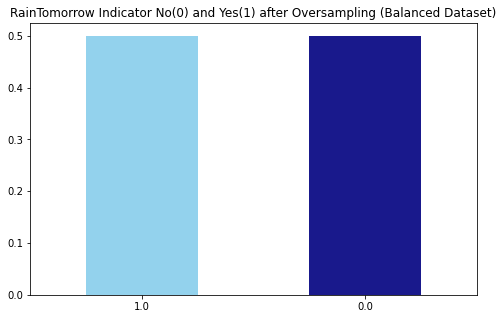

In [227]:
from sklearn.utils import resample

no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

Now, we will now check the missing data pattern in the dataset.

In [228]:
# # Missing Data Pattern in Training Data
# import seaborn as sns
# sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

Visibly, 'Evaporation','Sunshine','Cloud9am','Cloud3pm' are the features having high missing percentage. So we will check the missing data details for these 4 features.

In [229]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664


We observe that all 4 features have <50% missing data. So instead of completely discarding them, we will consider them in our model with proper imputation.

# Imputation and Transformation
We will impute categorical columns with mode, and then we will use label encoder to convert them into numeric ones. Once the full dataframe's all columns get converted to numeric ones, we will impute missing values (NaN etc.) using **MICE package (Multiple Imputation by Chained Equations)**. Afterwards, we will detect outliers using **Inter-Quartile Range** and remove them to get the final working data set. Finally, we will check correlation among different variables, and if we find any pair of highly correlated variables, we will discard one keeping the other.

In [230]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [231]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [232]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [233]:
import warnings
warnings.filterwarnings("ignore")

In [234]:
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [235]:
# MiceImputed.head()

Now, we will check whether all "NaN" values are imputed completely or not.

In [236]:
# MiceImputed.isna()

So, after MICE imputation, the dataframe does not have any "NaN" value. We will now detect and discard the outliers from data set based on Inter-Quartile Range.

In [237]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.120044
Sunshine            5.979485
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.684676
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64


In [238]:
# Removing outliers from dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(170669, 23)

We observe that the original dataset was having the shape (87927, 24). After running outlier-removal code snippet, the dataset is now having the shape (86065, 24). So, the dataset is now free of 1862 outliers. We will now check for multi-collinearity i.e. whether any feature is highly correlated with another.

In [239]:
# # Correlation Heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# corr = MiceImputed.corr()
# mask = np.triu(np.ones_like(corr, dtype=np.bool))
# f, ax = plt.subplots(figsize=(20, 20))
# cmap = sns.diverging_palette(250, 25, as_cmap=True)
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

The following pairs of features are having high correlation between them:

* MaxTemp and MinTemp
* Pressure9am and Pressure3pm
* Temp9am and Temp3pm
* Evaporation and MaxTemp
* MaxTemp and Temp3pm
But in no case, the correlation value is equal to a perfect "1". So we are not discarding any feature. 

However, we can dig deeper into pairwise correlation among these highly correlated features by looking at the following pairplot. Each of the pairplots shows very clearly distinguishable clusters of RainTomorrow "yes" and "no". There is very minimal overlap between them.

In [240]:
# sns.pairplot( data=MiceImputed, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow' )


# Feature Selection
We will use both filter method and wrapper method for feature selection.

**(1) Feature Selection by Filter Method (Chi-Square Value):** Before performing this, we need to standardize our data first. We are using MinMaxScaler instead of StandardScaler in order to avoid negative values.

In [241]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)
modified_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0.115284,0.041667,0.543417,0.514778,0.437385,0.569756,0.512042,0.866667,0.521127,0.866667,...,0.551807,0.222773,0.245714,0.298295,0.868449,0.420458,0.506775,0.530612,0.24783,0.0
1,0.115575,0.041667,0.375350,0.568966,0.374872,0.563868,0.745836,0.933333,0.521127,0.400000,...,0.247750,0.252666,0.328571,0.318182,0.339380,0.227713,0.514905,0.594388,0.24783,0.0
2,0.115866,0.041667,0.529412,0.583744,0.374872,0.695026,0.793365,1.000000,0.549296,0.866667,...,0.180182,0.302488,0.242857,0.343750,0.347461,0.173437,0.617886,0.566327,0.24783,0.0
3,0.116157,0.041667,0.425770,0.640394,0.374872,0.584743,0.762539,0.266667,0.239437,0.600000,...,0.259012,0.162986,0.528571,0.460227,0.297350,0.183513,0.539295,0.650510,0.24783,0.0
4,0.116448,0.041667,0.658263,0.746305,0.479060,0.638825,0.413485,0.866667,0.478873,0.066667,...,0.675683,0.332382,0.334286,0.267045,0.784042,0.693747,0.531165,0.732143,0.24783,0.0


In [242]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday'],
      dtype='object')


We can observe that "Sunshine", "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm" are having higher importance compared to other features.

**(2) Feature Selection by Wrapper Method (Random Forest):**

In [243]:
# from sklearn.feature_selection import SelectFromModel
# from sklearn.ensemble import RandomForestClassifier as rf

# X = MiceImputed.drop('RainTomorrow', axis=1)
# y = MiceImputed['RainTomorrow']
# selector = SelectFromModel(rf(n_estimators=100, random_state=0))
# selector.fit(X, y)
# support = selector.get_support()
# features = X.loc[:,support].columns.tolist()
# print(features)
# print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

*This is quite interesting to see all feature importances except for RISK_MM are nearing to zero*. This is possible in two scenarios. Either when all the features have high correlation among each other or when the features actually have very very low relative feature importances w.r.t. the target variable. Since we already plotted correlation, we know that the first possibility is not true. We will cross-check if the second possibility is true by using **Permutation Importance**.

In [244]:
import warnings
warnings.filterwarnings("ignore")

In [245]:
# import eli5
# from eli5.sklearn import PermutationImportance

# perm = PermutationImportance(rf(n_estimators=100, random_state=0).fit(X,y),random_state=1).fit(X,y)
# eli5.show_weights(perm, feature_names = X.columns.tolist())

We can observe that all features except "RISK_MM" have very very low relative importance (all nearing to zero) with respect to target variable "RainTomorrow". As explained by the dataset creator [Joe Young](http://www.kaggle.com/jsphyg), "RISKMM is the amount of rainfall in millimeters for the next day. It includes all forms of precipitation that reach the ground, such as rain, drizzle, hail and snow. And it was the column that was used to actually determine whether or not it rained to create the binary target. **Since it contains information directly about the target variable, including it would leak the future information to our model**" (Quoted from his comment). So "RISK_MM" is excluded from the model. "Date" is also excluded from the model for the obvious reason since it is not adding any relevance in the current context.

# Training with Different Models
We will split the entire data set into training (75%) and testing (25%) sets respectively. For getting better results, we will standardize our X_train and X_test data (i.e. features without target for training and testing data sets).

In [246]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [247]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [248]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, mean_squared_log_error, mean_squared_error, confusion_matrix, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    coh_kap = cohen_kappa_score(y_test, y_pred)
    log_los = log_loss(y_test, y_pred, normalize=True)
    mse = mean_squared_error(y_test, y_pred)
    msle = mean_squared_log_error(y_test, y_pred)
    time_taken = time.time()-t0
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    
    error_rate = (fp + fn) / len(y_pred)
    
    print("Accuracy = {}".format(accuracy))
    print("Error Rate = {}".format(error_rate))
    print("Kappa Score = {}".format(coh_kap))
    print("Log Loss = {}".format(log_los))
    print("Specificity = {}".format(specificity))
    print("Sensitivity = {}".format(sensitivity))
    print("Time taken = {}".format(time_taken))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("MSE = {}".format(mse))    
    print("MSLE = {}".format(msle))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)    
    
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, accuracy, roc_auc, coh_kap, time_taken

**Model-1: Decision Tree (Gini)**

Accuracy = 0.8601996812599606
Error Rate = 0.13980031874003937
Kappa Score = 0.717636303815612
Log Loss = 4.828595290028975
Specificity = 0.8584530340466519
Sensitivity = 0.8624195007717281
Time taken = 0.5463643074035645
ROC Area under Curve = 0.86043626740919
MSE = 0.13980031874003937
MSLE = 0.06716748448537713
              precision    recall  f1-score   support

         0.0    0.88802   0.85845   0.87299     23879
         1.0    0.82741   0.86242   0.84455     18789

    accuracy                        0.86020     42668
   macro avg    0.85771   0.86044   0.85877     42668
weighted avg    0.86133   0.86020   0.86046     42668



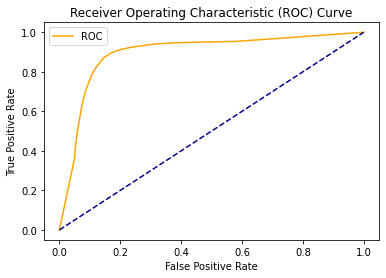

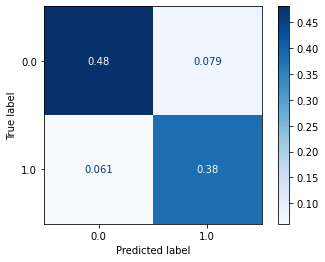

In [249]:
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

**Decision Tree (Entropy)**

Accuracy = 0.8536608230992782
Error Rate = 0.14633917690072185
Kappa Score = 0.7052831123502528
Log Loss = 5.0544468709505646
Specificity = 0.841869425017798
Sensitivity = 0.8686465485124275
Time taken = 0.6371798515319824
ROC Area under Curve = 0.8552579867651128
MSE = 0.14633917690072185
MSLE = 0.07030909859626065
              precision    recall  f1-score   support

         0.0    0.89066   0.84187   0.86558     23879
         1.0    0.81211   0.86865   0.83943     18789

    accuracy                        0.85366     42668
   macro avg    0.85138   0.85526   0.85250     42668
weighted avg    0.85607   0.85366   0.85406     42668



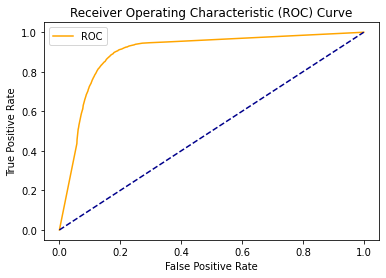

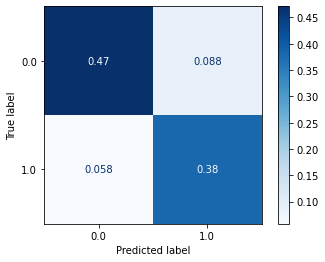

In [250]:
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt",
             'criterion': 'entropy'
            }

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

**Model-2: KNN**

Accuracy = 0.8344192368988469
Error Rate = 0.16558076310115308
Kappa Score = 0.6668976387082339
Log Loss = 5.719037234120065
Specificity = 0.820595502324218
Sensitivity = 0.8519878652403001
Time taken = 159.17966985702515
ROC Area under Curve = 0.836291683782259
MSE = 0.16558076310115308
MSLE = 0.07955377667882473
              precision    recall  f1-score   support

         0.0    0.87572   0.82060   0.84726     23879
         1.0    0.78888   0.85199   0.81922     18789

    accuracy                        0.83442     42668
   macro avg    0.83230   0.83629   0.83324     42668
weighted avg    0.83748   0.83442   0.83491     42668



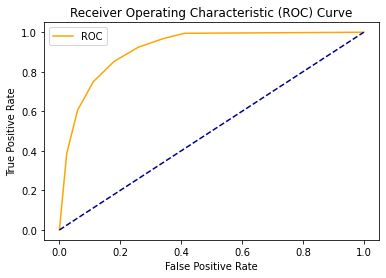

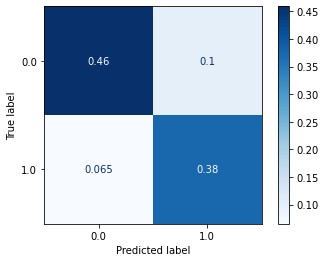

In [251]:
from sklearn.neighbors import KNeighborsClassifier
model_lr = KNeighborsClassifier(n_neighbors=7)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

**Model-3: Neural Network (Multilayer Perceptron) logistic**

Accuracy = 0.8705821693072091
Error Rate = 0.12941783069279086
Kappa Score = 0.7376360636420614
Log Loss = 4.469986568693674
Specificity = 0.8814439465639264
Sensitivity = 0.856777901963915
Time taken = 204.02648854255676
ROC Area under Curve = 0.8691109242639208
MSE = 0.12941783069279086
MSLE = 0.06217918681110687
              precision    recall  f1-score   support

         0.0    0.88664   0.88144   0.88404     23879
         1.0    0.85044   0.85678   0.85360     18789

    accuracy                        0.87058     42668
   macro avg    0.86854   0.86911   0.86882     42668
weighted avg    0.87070   0.87058   0.87063     42668



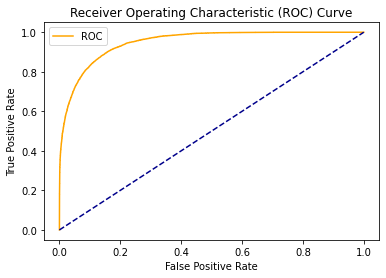

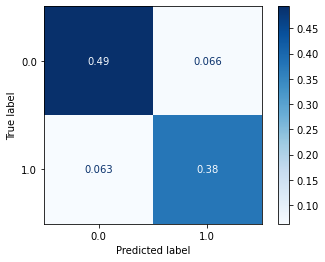

In [252]:
from sklearn.neural_network import MLPClassifier

params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'logistic',
             'solver': 'lbfgs',
             'max_iter': 500}

model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)

**Identity**

Accuracy = 0.795232961469954
Error Rate = 0.20476703853004594
Kappa Score = 0.5822290232203007
Log Loss = 7.072475630476443
Specificity = 0.8375978893588508
Sensitivity = 0.7413912395550588
Time taken = 5.539704322814941
ROC Area under Curve = 0.7894945644569549
MSE = 0.20476703853004594
MSLE = 0.09838094081286504
              precision    recall  f1-score   support

         0.0    0.80455   0.83760   0.82074     23879
         1.0    0.78223   0.74139   0.76126     18789

    accuracy                        0.79523     42668
   macro avg    0.79339   0.78949   0.79100     42668
weighted avg    0.79472   0.79523   0.79455     42668



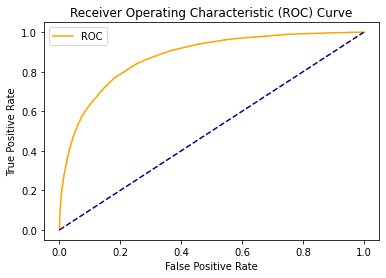

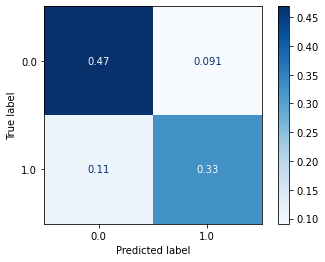

In [253]:
from sklearn.neural_network import MLPClassifier

params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'identity',
             'solver': 'lbfgs',
             'max_iter': 500}

model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)

**tanh**

Accuracy = 0.8993156463860504
Error Rate = 0.10068435361394956
Kappa Score = 0.7959280088095746
Log Loss = 3.477556278531692
Specificity = 0.9063612379077851
Sensitivity = 0.8903613816594816
Time taken = 278.93829870224
ROC Area under Curve = 0.8983613097836335
MSE = 0.10068435361394956
MSLE = 0.04837410114822802
              precision    recall  f1-score   support

         0.0    0.91309   0.90636   0.90971     23879
         1.0    0.88210   0.89036   0.88621     18789

    accuracy                        0.89932     42668
   macro avg    0.89759   0.89836   0.89796     42668
weighted avg    0.89944   0.89932   0.89936     42668



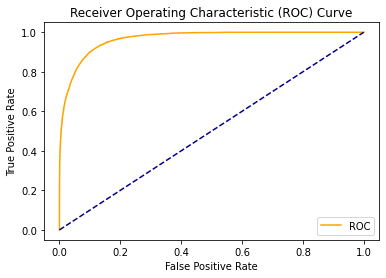

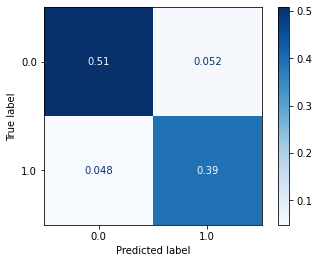

In [254]:
from sklearn.neural_network import MLPClassifier

params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'tanh',
             'solver': 'lbfgs',
             'max_iter': 500}

model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)

**relu**

Accuracy = 0.894768913471454
Error Rate = 0.10523108652854599
Kappa Score = 0.7865067988955398
Log Loss = 3.6345950948760675
Specificity = 0.9058587043008501
Sensitivity = 0.880674862951727
Time taken = 131.4625883102417
ROC Area under Curve = 0.8932667836262885
MSE = 0.10523108652854599
MSLE = 0.05055859268052697
              precision    recall  f1-score   support

         0.0    0.90609   0.90586   0.90597     23879
         1.0    0.88039   0.88067   0.88053     18789

    accuracy                        0.89477     42668
   macro avg    0.89324   0.89327   0.89325     42668
weighted avg    0.89477   0.89477   0.89477     42668



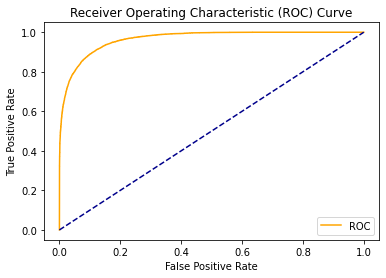

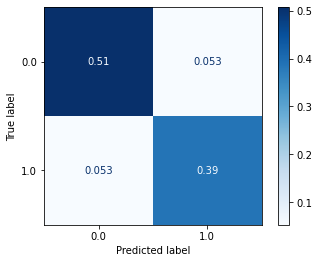

In [255]:
from sklearn.neural_network import MLPClassifier

params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'relu',
             'solver': 'lbfgs',
             'max_iter': 500}

model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)

**Model-4: Random Forest**

Accuracy = 0.9265960438736289
Error Rate = 0.07340395612637104
Kappa Score = 0.8517906871231153
Log Loss = 2.535320175929002
Specificity = 0.9165375434482181
Sensitivity = 0.9393794241311405
Time taken = 32.93404459953308
ROC Area under Curve = 0.9279584837896794
MSE = 0.07340395612637104
MSLE = 0.035267151954434396
              precision    recall  f1-score   support

         0.0    0.95053   0.91654   0.93323     23879
         1.0    0.89854   0.93938   0.91851     18789

    accuracy                        0.92660     42668
   macro avg    0.92454   0.92796   0.92587     42668
weighted avg    0.92764   0.92660   0.92674     42668



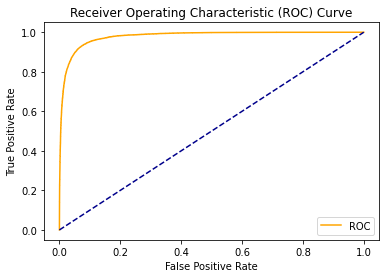

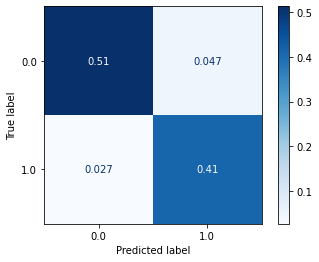

In [256]:
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

**Model-5: Light GBM**

Accuracy = 0.8655667010405925
Error Rate = 0.13443329895940753
Kappa Score = 0.7261303356541291
Log Loss = 4.643208633916874
Specificity = 0.8950123539511705
Sensitivity = 0.8281441268827505
Time taken = 3.606455087661743
ROC Area under Curve = 0.8615782404169605
MSE = 0.13443329895940753
MSLE = 0.06458888365601395
              precision    recall  f1-score   support

         0.0    0.86875   0.89501   0.88168     23879
         1.0    0.86124   0.82814   0.84437     18789

    accuracy                        0.86557     42668
   macro avg    0.86499   0.86158   0.86303     42668
weighted avg    0.86544   0.86557   0.86525     42668



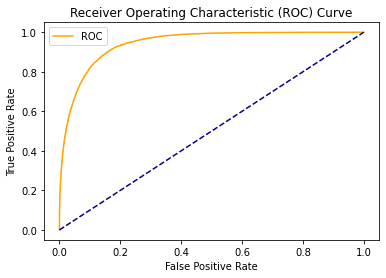

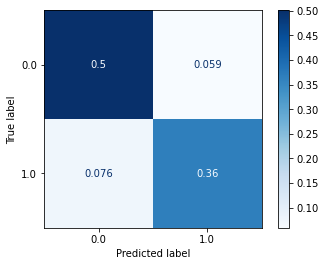

In [257]:
import lightgbm as lgb
params_lgb ={'colsample_bytree': 0.95, 
         'max_depth': 16, 
         'min_split_gain': 0.1, 
         'n_estimators': 200, 
         'num_leaves': 50, 
         'reg_alpha': 1.2, 
         'reg_lambda': 1.2, 
         'subsample': 0.95, 
         'subsample_freq': 20}

model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb, accuracy_lgb, roc_auc_lgb, coh_kap_lgb, tt_lgb = run_model(model_lgb, X_train, y_train, X_test, y_test)

**Model-6: CatBoost**

Accuracy = 0.9392050248429736
Error Rate = 0.060794975157026344
Kappa Score = 0.8776540964755455
Log Loss = 2.0998218514206206
Specificity = 0.9155324762343482
Sensitivity = 0.9692905423386023
Time taken = 163.66914248466492
ROC Area under Curve = 0.9424115092864753
MSE = 0.060794975157026344
MSLE = 0.02920912904527548
              precision    recall  f1-score   support

         0.0    0.97429   0.91553   0.94400     23879
         1.0    0.90029   0.96929   0.93352     18789

    accuracy                        0.93921     42668
   macro avg    0.93729   0.94241   0.93876     42668
weighted avg    0.94170   0.93921   0.93938     42668



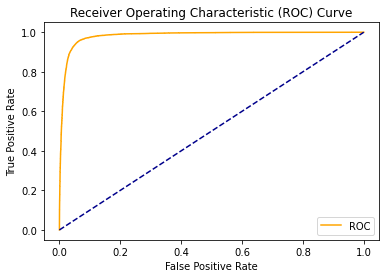

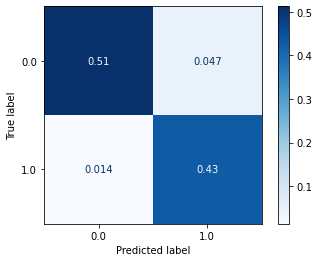

In [258]:
import catboost as cb
params_cb ={'iterations': 50,
            'max_depth': 16}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, accuracy_cb, roc_auc_cb, coh_kap_cb, tt_cb = run_model(model_cb, X_train, y_train, X_test, y_test, verbose=False)

**Model-7: XGBoost**

Accuracy = 0.9496109496578232
Error Rate = 0.050389050342176805
Kappa Score = 0.8984891049787654
Log Loss = 1.7404080379648497
Specificity = 0.928723983416391
Sensitivity = 0.9761562616424504
Time taken = 139.49419617652893
ROC Area under Curve = 0.9524401225294207
MSE = 0.050389050342176805
MSLE = 0.024209571105374823
              precision    recall  f1-score   support

         0.0    0.98020   0.92872   0.95377     23879
         1.0    0.91508   0.97616   0.94463     18789

    accuracy                        0.94961     42668
   macro avg    0.94764   0.95244   0.94920     42668
weighted avg    0.95152   0.94961   0.94975     42668



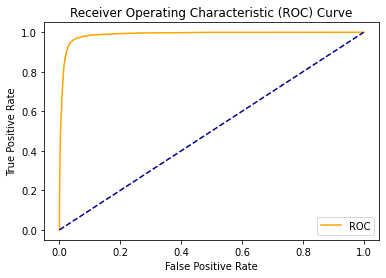

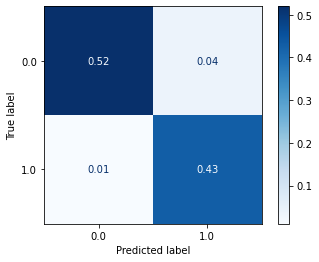

In [259]:
import xgboost as xgb
params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)